In [1]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="tp5-championstweet")):
    res = es.indices.create(index="tp5-championstweet")  
    pprint(res)

In [4]:
#LISTAR LOS ARCHIVOS DEL DATASET
import json
import os
files = os.listdir("split_dataset_1")
pprint(len(files))

354585


In [5]:
from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('split_dataset_1/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="tp5-championstweet", doc_type="_doc")
        tweets=[]

In [18]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
from pandas.io.json import json_normalize
import pandas as pd
res = es.search(index="tp5-championstweet", body={"size":1000, "query": {"match_all": {}}})

df = json_normalize(res['hits']['hits'])

print(df.columns)


print(pd.unique(df['_source.location']))

#print(df['_source.location'][:10])

#print("Got %d Hits:" % res['hits']['total'])
#for hit in res['hits']['hits']:
#    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])

[None ' In a galaxy far, far away...' 'Caxias city' 'chile' 'Islamabad'
 'Costa Rica ' ' Manchester/Nigeria ' 'İstanbul, Türkiye'
 'Sumedang, West Java' 'LIFE' 'لوس فيغالوس الفوقا ' 'Oasis'
 'Sutton-in-Craven, England' 'palestine-Gaza'
 'Australia  / LA  / Everywhere!' 'Pittsburgh / Williamsport'
 'Port Harcourt | Abu Dhabi' 'Earth🌏' 'Santiago, Chile' 'Florida- U.S.'
 'Johannesburg, South Africa' 'BEYKOZ' 'All over the world'
 'J1王国J2県J3市JFL区' 'karachi, pakistan' 'Tampa, FL '
 'Liverpool-Warwick-Lagos-Abuja' 'Sohag' 'Bakersfield, CA'
 'Gettin a j00cy p0mp' 'Moreno Valley, CA' 'São Paulo' 'Liverpool'
 'المملكة العربية السعودية' 'Colombia mija' 'Bns'
 'Recife, Pernambuco, Brasil' 'Magelang, Indonesia'
 'Givat Nili Holy Land Israel' 'Lagos' 'Lagos, Nigeria'
 'Espanya, Paisos espanyols' 'Panama City, Panama. ' 'Nottingham, England'
 'Martinique' 'camila and madison follow🌿' 'Lagos/Nigeria'
 'Abuja, Nigeria' 'Bogotá, D.C., Colombia' 'Jeumont, France'
 'Toronto, Ontario' 'West Lafayette/Indi

In [4]:
#CONSULTA: ¿Cuántos tweets cada minuto?
res = es.search(index="tp5-championstweet", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})

#for data in res['aggregations']['tweets_over_time']['buckets']:
#    print(data['doc_count'])

In [5]:
import pandas as pd

df_tweetsByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_tweetsByMinutes = df_tweetsByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_tweetsByMinutes[:10]

,nb_tweets,timestamp
0,43,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [6]:
df_tweetsByMinutes_filtered = df_tweetsByMinutes.drop(df_tweetsByMinutes[df_tweetsByMinutes.timestamp < 1527357600000 ].index)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,1527357600000
283,0,1527357660000
284,0,1527357720000
285,0,1527357780000
286,0,1527357840000
287,0,1527357900000
288,0,1527357960000
289,0,1527358020000
290,0,1527358080000
291,0,1527358140000


In [7]:
import datetime

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_tweetsByMinutes_filtered['timestamp']=df_tweetsByMinutes_filtered['timestamp'].apply(timestamp2date)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,14:00:00
283,0,14:01:00
284,0,14:02:00
285,0,14:03:00
286,0,14:04:00
287,0,14:05:00
288,0,14:06:00
289,0,14:07:00
290,0,14:08:00
291,0,14:09:00


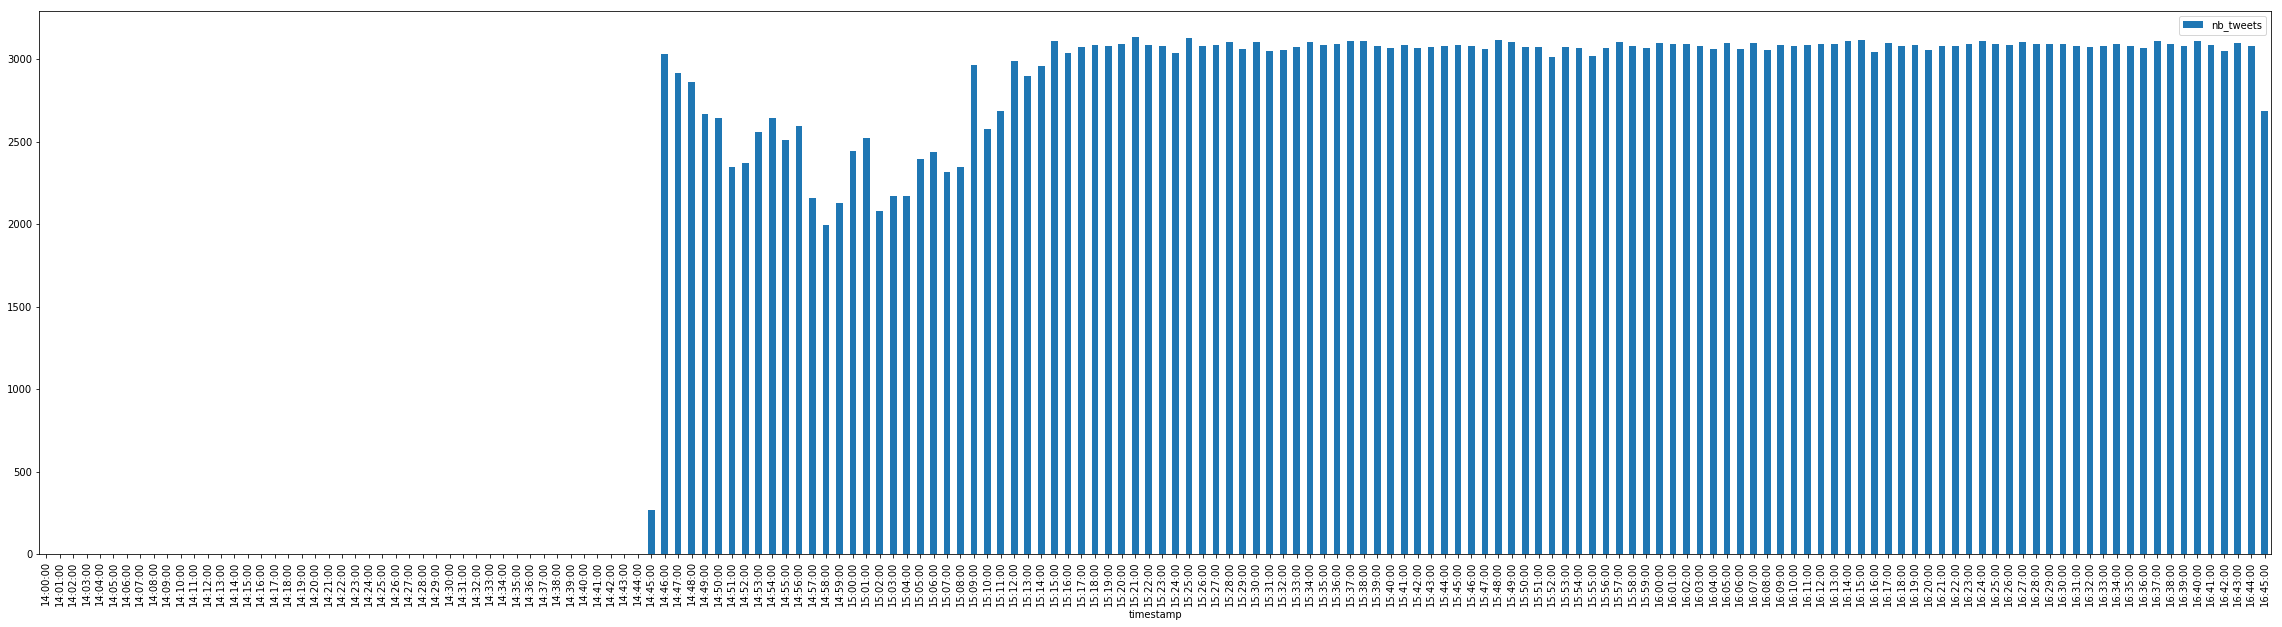

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

df_tweetsByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

In [13]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"term":{"text":"goal"}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])

Got 16803 Hits:
TWEET:Goal goal goal goal goal goal!!!!!!!!!!!!!!!!!!!!!! #RealMadrid #RMALIV #UCLfinal Preveza Epirus: Sat May 26 20:13:28 +0000 2018
TWEET:Goal 
Goal
Goal
Goal
#UCLfinal Olouwadamissi: Sat May 26 19:57:14 +0000 2018
TWEET:Super goal goal goal goal goal https://t.co/FVh1CVOEGA Abouuuuuuuuuuuuu Impala: Sat May 26 20:12:56 +0000 2018
TWEET:GOAL GOAL GOAL GOAL GOOOAAAAL MANEEEEE #UCLFinal NooR: Sat May 26 20:01:07 +0000 2018
TWEET:Goal! Goal!! Goal!!! Sadio Mane #UCLfinal P!: Sat May 26 20:00:31 +0000 2018
TWEET:Goal! Goal! Goal! Typical Liverpool goalkeepers #UCLfinal #HalaMadrid Tlholo conquer: Sat May 26 19:56:24 +0000 2018
TWEET:#UCLfinal

Never felt this alive. Goal goal goal Gagan: Sat May 26 20:01:30 +0000 2018
TWEET:Yeyyyy😃😃 goal ,goal😃😃😃
#UCLfinal A girl with a brain without mind.: Sat May 26 20:25:25 +0000 2018
TWEET:Goal Goal Goal!!!!! 
@KraksTV 
#UCLFinal https://t.co/H8cDjge8hi Unilag Ajebutter: Sat May 26 19:56:06 +0000 2018
TWEET:Mane goal issa goal #uclfin

1) ¿Cuántos tweets tienen la palabra "liverpool"? ¿Cómo se distribuye los tweets en el tiempo (ver en un histograma)


In [63]:
res_liv = es.search(index = 'tp5-championstweet', 
                body={"query": {"term":{"text":"liverpool"}},
                      "size": 0,
                      "aggs" : { "tweets_over_time" : \
                                 { "date_histogram" : { "field" : \
                                                       "timestamp", "interval" : "1m"\
                                                      }}}})

df_liv = pd.DataFrame(res_liv['aggregations']['tweets_over_time']['buckets'])
df_liv = df_liv.rename(columns={'key': 'timestamp', 'doc_count': 'liv_tweets'})
df_liv_filtrado = df_liv.drop(df_liv[df_liv.timestamp < 1527357600000 ].index)
df_liv_filtrado['timestamp']=df_liv_filtrado['timestamp'].apply(timestamp2date)

print(df_liv_filtrado['liv_tweets'].sum())




44160


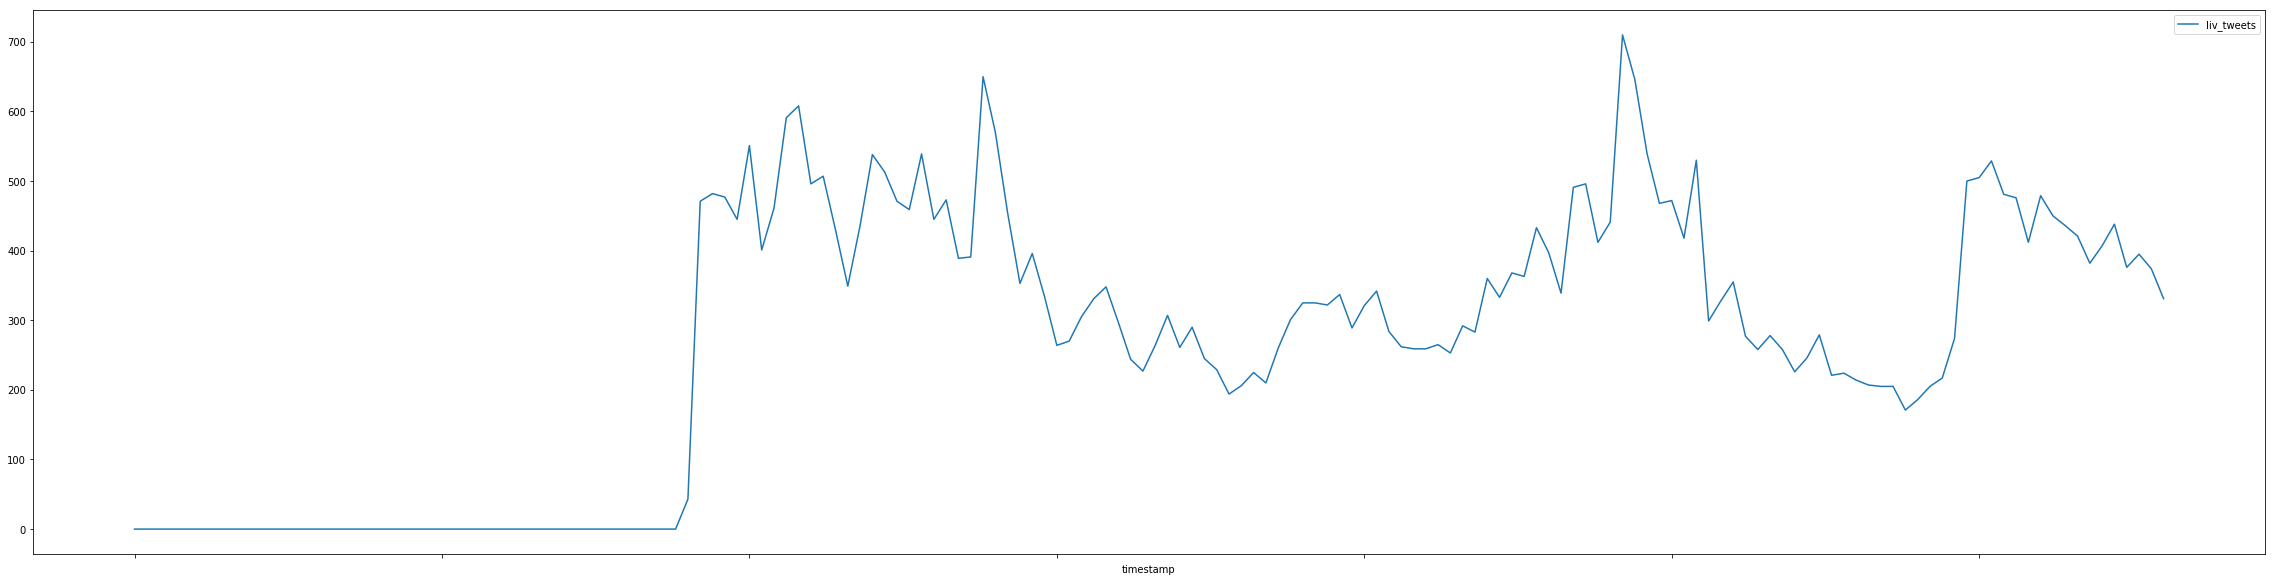

In [64]:
df_liv_filtrado.plot(kind='line',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

2) ¿De dónde vienen los tweets? (utilizar el campo 'location')


In [14]:
res_location = es.search(index="tp5-championstweet", body={"query": {"match_all": {}},
                                                           "size":0,
                                                           "aggs":{
                                                               "by_location":{
                                                                   "terms" :{
                                                                       "field":"location.keyword",
                                                                       "size":250000
                                                                       }}}})

df_location = pd.DataFrame(res_location['aggregations']['by_location']['buckets'])
df_location = df_location.rename(columns={'key': 'location', 'doc_count': 'tweets_from_location'})


print(df_location['location'])

0                     Lagos, Nigeria
1                            Nigeria
2                    London, England
3                     Nairobi, Kenya
4                       South Africa
5         Johannesburg, South Africa
6                             London
7                             Brasil
8                     United Kingdom
9             Rio de Janeiro, Brasil
10                         Indonesia
11                    Abuja, Nigeria
12                      Cairo, Egypt
13                     United States
14                          Malaysia
15           England, United Kingdom
16                            España
17                             Lagos
18                             Egypt
19            Pretoria, South Africa
20                            México
21                             Kenya
22                            Madrid
23                      Accra, Ghana
24                          Colombia
25                             India
26                     Paris, France
2

3) ¿Cuántos tweets tienen las palabras "liverpool" y "goal"? (ver en un histograma)


1651


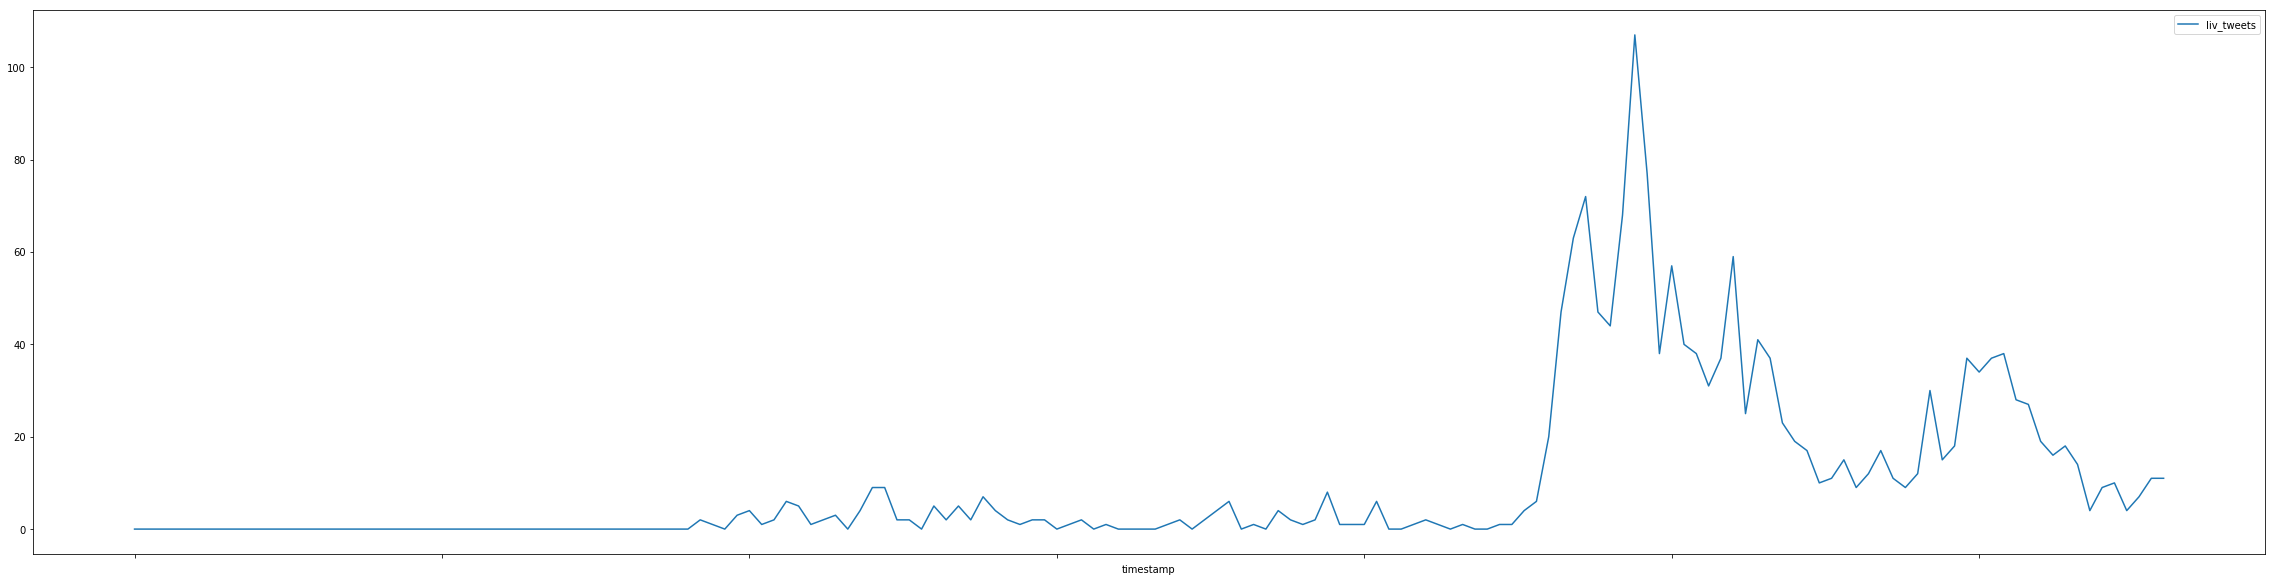

In [28]:
res_liver = es.search(index = 'tp5-championstweet', 
                body={"query":{
                    "match":{
                        "text":{
                            "query" :"liverpool goal",
                            "operator":"and"}}},
                      "size": 0,
                      "aggs" : { "tweets_over_time" : \
                                 { "date_histogram" : { "field" : \
                                                       "timestamp", "interval" : "1m"\
                                                      }}}})

df_liver = pd.DataFrame(res_liver['aggregations']['tweets_over_time']['buckets'])
df_liver = df_liver.rename(columns={'key': 'timestamp', 'doc_count': 'liv_tweets'})
df_liver_filtrado = df_liver.drop(df_liver[df_liver.timestamp < 1527357600000 ].index)
df_liver_filtrado['timestamp']=df_liver_filtrado['timestamp'].apply(timestamp2date)

print(df_liver_filtrado['liv_tweets'].sum())

df_liver_filtrado.plot(kind='line',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

4) Graficar un Pie Chart comparando el número de tweets con: 
  - la palabra 'liverpool' 
  - la palabra 'madrid'
  - la palabra 'madrid' y 'liverpool' 
  - ninguna de las palabras


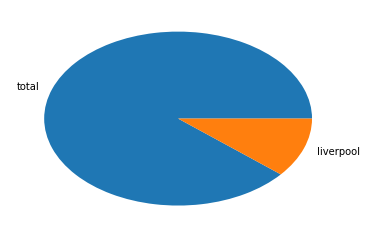

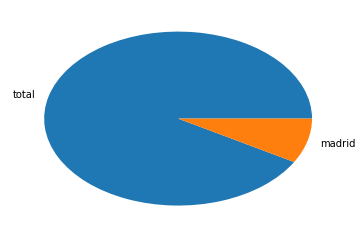

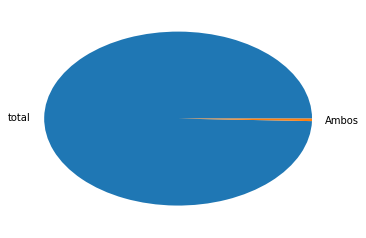

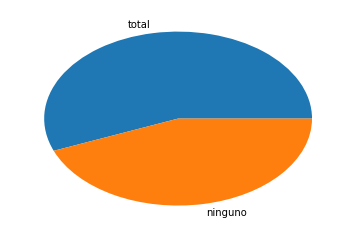

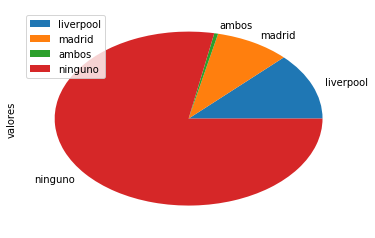

In [89]:
res_todos = es.count(index="tp5-championstweet", body={"query": {"match_all": {}}})
df_todos = pd.DataFrame(res_todos)
total = df_todos['count']['total']
#print(total)

res_liv_count = es.count(index = 'tp5-championstweet', body={"query": {"term":{"text":"liverpool"}}})
liv_count = pd.DataFrame(res_liv_count)
liv_c = liv_count['count']['total']
#print(liv_c)

plt.pie([total, liv_c], labels = ['total','liverpool'])
plt.show()


res_mad_count = es.count(index = 'tp5-championstweet', body={"query": {"term":{"text":"madrid"}}})
mad_count = pd.DataFrame(res_mad_count)
mad_c = mad_count['count']['total']
#print(mad_c)
plt.pie([total, mad_c], labels = ['total','madrid'])
plt.show()

res_liv_mad_count = es.count(index = 'tp5-championstweet', body={"query":{"match":{"text":{"query" :"liverpool goal",
                                                                                    "operator":"and"}}}})
liv_mad_count = pd.DataFrame(res_liv_mad_count)
liv_mad_c = liv_mad_count['count']['total']
#print(liv_mad_c)
plt.pie([total, liv_mad_c], labels = ['total','Ambos'])
plt.show()

non = total - (liv_c + mad_c)
#print(non)
plt.pie([total, non], labels = ['total','ninguno'])
plt.show()


datos = {'etiquetas':['liverpool', 'madrid' , 'ambos', 'ninguno'],
        'valores':[liv_c, mad_c, liv_mad_c, non]}

df_datos = pd.DataFrame(datos, columns = ['etiquetas', 'valores'])
#print(df_datos)

df_datos.plot.pie(y='valores',labels=df_datos['etiquetas'])
plt.show()




                                                           

5) ¿Cuáles son los emoticons más frecuentes? A partir de las visualizaciones disponibles en las librerias MatplotLib y/o Seaborn (seaborn.pydata.org), proponer una visualización para observar las emociones expresadas durante el partido.

Crear un diccionario de emociones con un contador, iterar sobre los tweets y cada vez que aparezca una emocion aumtar el contador, luego hacer un grafico de barra para ver cuales emociones estan más presentes en los tweets.